## Overview
This examines why there are more labels than you start out with when you label an annotation volume. For example, there are 236 unique labels in Collman15v2 dataset, but using skimage.measure.label on the annotation volume returns 302 labels.

### Summary
In an annotation perspective, a synapse is between a single pre-synapse and a single post-synapse. As such, there may be more than 1 synaptic clefts between one pre-synapse and another post-synapse. This results in some annotations having more than 1 synaptic area, which causes skimage.measure.label to think that they are separate "labels" when they are not.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import from_levels_and_colors
from skimage.measure import label

In [2]:
file = np.load('../data/collman15v2.npz')

annotation_collman = file['annotation']

In [3]:
uniques = np.unique(annotation_collman)

len(uniques[1:])

236

In [4]:
annotation_labels = label(annotation_collman > 0)

label_uniques = np.unique(annotation_labels)

len(label_uniques[1:])

302

In [5]:
collman_bins = np.bincount(annotation_collman.ravel())[1:]
collman_bins = collman_bins[np.nonzero(collman_bins)] #There is one number that is skipped

In [6]:
np.min(collman_bins)

1071

In [7]:
label_bins = np.bincount(annotation_labels.ravel())[1:]

In [8]:
np.min(label_bins)

589

Since the minimum size in annotation_labels is 589, it can be assumed that there aren't any randomly annotation voxels floating around in the annotation volume.

In [9]:
def get_unique_overlap(foreground, background, i):
    '''
    Calculates the number of unique background labels in the foreground at i
    Does not count background label of 0
    '''

    r = np.any(foreground==i, axis=(1, 2))
    c = np.any(foreground==i, axis=(0, 2))
    z = np.any(foreground==i, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    foreground = foreground[rmin:rmax+1, cmin:cmax+1, zmin:zmax+1]
    background = background[rmin:rmax+1, cmin:cmax+1, zmin:zmax+1]
    
    #This runs about 4 times faster than np.unique()
    overlaps = np.multiply((foreground == i), background)
    bins = np.zeros(np.max(overlaps) + 1, dtype=int)
    bins[overlaps.ravel()] = 1
    uniques = np.nonzero(bins)[0]

    num_unique = len(uniques)

    #0 is background label
    #should not count as a detection if
    #the prediction overlaps with the background
    if 0 in uniques:
        num_unique -= 1
        
    if num_unique > 1:
        return (i, num_unique)

In [10]:
def bbox_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return (rmin, rmax + 1), (cmin, cmax + 1), (zmin, zmax + 1)

Let's look at which annotations split into 2 or more labels after skimage.label. 

In [11]:
problematic_annotations = [get_unique_overlap(annotation_collman, annotation_labels, i) for i in uniques[1:]]

In [12]:
problematic_annotations = list(filter(None, problematic_annotations))

In [13]:
problematic_annotations

[(2, 2),
 (4, 2),
 (5, 2),
 (6, 2),
 (8, 2),
 (16, 2),
 (17, 2),
 (19, 4),
 (24, 2),
 (25, 3),
 (28, 2),
 (38, 2),
 (40, 2),
 (45, 2),
 (51, 2),
 (53, 2),
 (54, 2),
 (55, 2),
 (56, 2),
 (63, 2),
 (65, 4),
 (77, 2),
 (83, 3),
 (85, 6),
 (103, 2),
 (112, 2),
 (135, 2),
 (137, 2),
 (138, 2),
 (140, 2),
 (143, 2),
 (159, 2),
 (160, 2),
 (165, 3),
 (175, 3),
 (179, 2),
 (187, 3),
 (188, 2),
 (193, 2),
 (203, 2),
 (204, 2),
 (218, 2),
 (219, 3),
 (221, 2),
 (223, 2),
 (226, 2),
 (230, 2),
 (231, 2),
 (235, 2),
 (236, 2),
 (237, 3)]

Let's look at annotation 85. This has 6 separate labels in one annotation. Basically, this synapse is part of the same pre-synaptic and post-synaptic cell, but it has few common characteristics:
  1. Synapse starts out at 2 different places.
  2. It skips a couple of Z slices
  3. Some annotations do not overlap at all
  
Plots below show individual labels with different colors.

https://viz.boss.neurodata.io/#!{'layers':{'annotation':{'type':'segmentation'_'source':'boss://https://api.boss.neurodata.io/collman/collman15v2/annotation?'}_'EM25K':{'type':'image'_'source':'boss://https://api.boss.neurodata.io/collman/collman15v2/EM25K'_'opacity':0.56}}_'navigation':{'pose':{'position':{'voxelSize':[2.240000009536743_2.240000009536743_70]_'voxelCoordinates':[4024.9990234375_2660.99951171875_11]}}_'zoomFactor':2.240000009536743}}

In [14]:
z, y, x = bbox_3D(annotation_collman == 85)
print(z, y, x)

(11, 19) (2527, 2683) (3916, 4214)


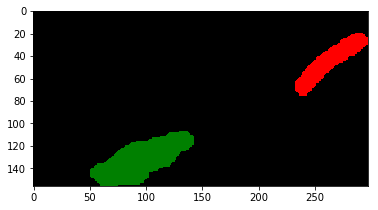

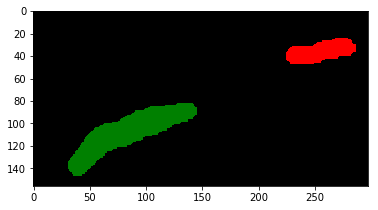

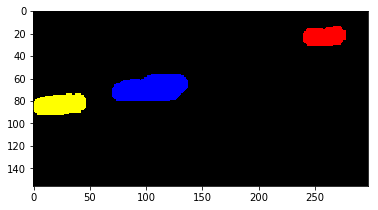

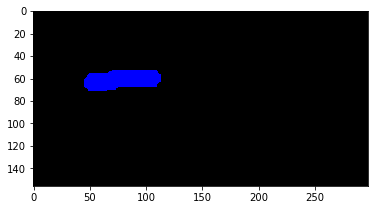

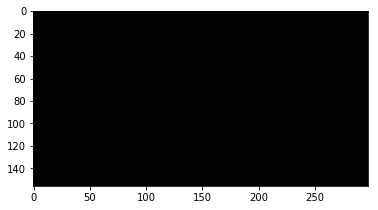

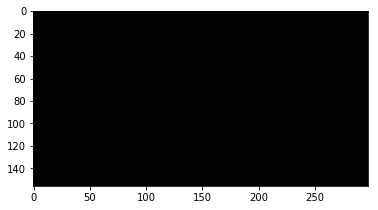

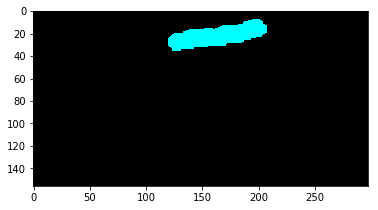

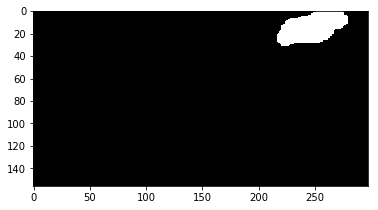

In [15]:
data = np.multiply(annotation_collman == 85, annotation_labels)[z[0]:z[1], y[0]:y[1], x[0]:x[1]]

cmap, norm = from_levels_and_colors(np.unique(data),['black','red', 'green','blue', 'yellow', 'cyan'])

for i in data:
    plt.figure()
    plt.imshow(i, cmap=cmap, norm=norm)
    plt.show()

Let's look at annotation 65. This has 4 separate labels in one annotation. Similar to synapse 85:
  1. Synapse starts out at 1 place, but separates into 3 in one slice.
  2. Some annotations do not overlap at all
 
https://viz.boss.neurodata.io/#!{'layers':{'annotation':{'type':'segmentation'_'source':'boss://https://api.boss.neurodata.io/collman/collman15v2/annotation?'}_'EM25K':{'type':'image'_'source':'boss://https://api.boss.neurodata.io/collman/collman15v2/EM25K'_'opacity':0.56}}_'navigation':{'pose':{'position':{'voxelSize':[2.240000009536743_2.240000009536743_70]_'voxelCoordinates':[5868.00146484375_1267.9971923828125_23]}}_'zoomFactor':2.240000009536743}}

In [16]:
z, y, x = bbox_3D(annotation_collman == 65)
print(z, y, x)

(21, 26) (977, 1296) (5822, 6001)


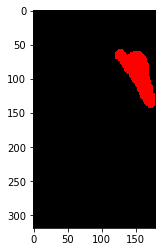

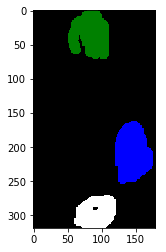

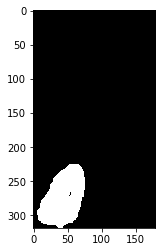

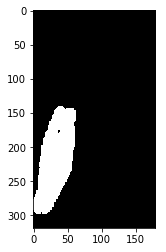

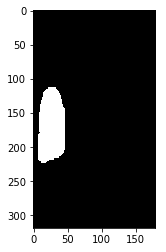

In [17]:
data = np.multiply(annotation_collman == 65, annotation_labels)[z[0]:z[1], y[0]:y[1], x[0]:x[1]]

cmap, norm = from_levels_and_colors(np.unique(data),['black','red', 'green','blue'])

for i in data:
    plt.figure()
    plt.imshow(i, cmap=cmap, norm=norm)
    plt.show()

Let's look at annotation 19. This has 4 separate labels in one annotation. Similar to synapse 65:
  1. Synapse 19 starts at two different places and merge into 1.
  2. Annotations in different z slices do not necessarily overlap.
  
https://viz.boss.neurodata.io/#!{'layers':{'annotation':{'type':'segmentation'_'source':'boss://https://api.boss.neurodata.io/collman/collman15v2/annotation?'}_'EM25K':{'type':'image'_'source':'boss://https://api.boss.neurodata.io/collman/collman15v2/EM25K'_'opacity':0.56}}_'navigation':{'pose':{'position':{'voxelSize':[2.240000009536743_2.240000009536743_70]_'voxelCoordinates':[520.0012817382812_2558.995361328125_0]}}_'zoomFactor':2.240000009536743}}

In [18]:
z, y, x = bbox_3D(annotation_collman == 19)
print(z, y, x)

(0, 4) (2486, 2592) (318, 616)


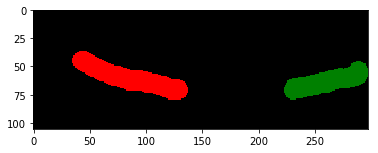

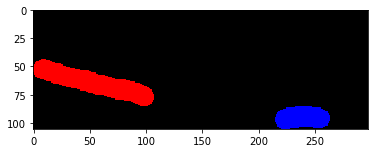

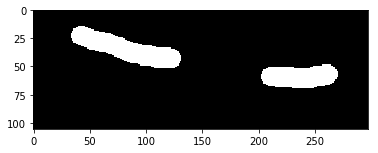

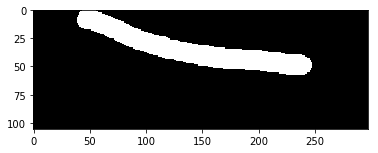

In [19]:
data = np.multiply(annotation_collman == 19, annotation_labels)[z[0]:z[1], y[0]:y[1], x[0]:x[1]]

cmap, norm = from_levels_and_colors(np.unique(data),['black','red', 'green','blue'])

for i in data:
    plt.figure()
    plt.imshow(i, cmap=cmap, norm=norm)
    plt.show()

Let's look at annotation 112. This has 2 separate labels in one annotation. Again:
  1. Annotations in different z slices do not necessarily overlap.

https://viz.boss.neurodata.io/#!{'layers':{'annotation':{'type':'segmentation'_'source':'boss://https://api.boss.neurodata.io/collman/collman15v2/annotation?'}_'EM25K':{'type':'image'_'source':'boss://https://api.boss.neurodata.io/collman/collman15v2/EM25K'_'opacity':0.56}}_'navigation':{'pose':{'position':{'voxelSize':[2.240000009536743_2.240000009536743_70]_'voxelCoordinates':[2414.000244140625_3195.99560546875_19]}}_'zoomFactor':2.240000009536743}}

In [20]:
z, y, x = bbox_3D(annotation_collman == 112)
print(z, y, x)

(19, 24) (3003, 3222) (2286, 2463)


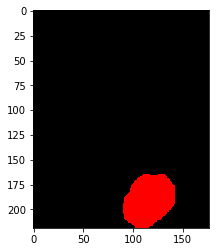

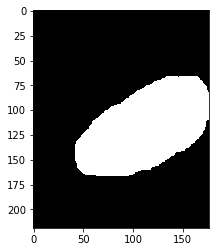

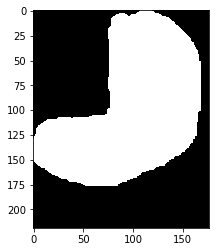

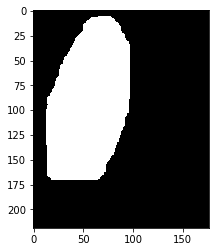

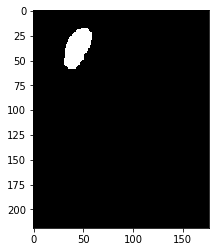

In [22]:
data = np.multiply(annotation_collman == 112, annotation_labels)[z[0]:z[1], y[0]:y[1], x[0]:x[1]]

cmap, norm = from_levels_and_colors(np.unique(data),['black','red'])

for i in data:
    plt.figure()
    plt.imshow(i, cmap=cmap, norm=norm)
    plt.show()